In [ ]:
import tensorflow as tf
import unitvelo as utv
import numpy as np
import matplotlib.pyplot as plt
from anndata import AnnData
import scvelo as scv
import scanpy as sc
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
import os
from scvelo.plotting.simulation import compute_dynamics

print ("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [22]:
adata_true=sc.read_h5ad('./data/adata_true.h5ad')
adata_unitvelo = sc.read_h5ad('./data/adata_unitvelo.h5ad')


In [3]:
velo = utv.config.Configuration()
velo.R2_ADJUST = False
velo.IROOT = None
velo.FIT_OPTION = '1'
velo.GPU = 0

In [20]:
def rbf(x, height, sigma, tau, offset_rbf):
    return height * np.exp(-sigma * (x - tau) * (x - tau)) + offset_rbf

def rbf_deri(x, height, sigma, tau, offset_rbf):
    return (rbf(x, height, sigma, tau, offset_rbf) - offset_rbf) * (-sigma * 2 * (x - tau))

def rbf_u(x, height, sigma, tau, offset_rbf, beta, gamma, intercept):
    return (rbf_deri(x, height, sigma, tau, offset_rbf) + gamma * rbf(x, height, sigma, tau, offset_rbf)) / beta + intercept

def plot_range(
    gene_name, 
    adata, 
    true_color='purple',
    fit_color=None,
    cmap='plasma',
    config_file=None, 
    save_path=None, 
    show_ax=False,
    show_legend=True,
    time_metric='latent_time',
    palette='YlGnBu_r',
    size=50, 
    adata_true=None,
    ncols=None 
):
    """
    (Modified) Plots the phase portrait for one or more genes with UniTVelo RBF fitting.
    The function now only supports batch plotting, as show_details logic is removed.
    """

    if config_file is None:
        raise ValueError('Attribute `config_file` must be set.')

    if time_metric == 'latent_time':
        if 'latent_time' not in adata.obs.columns:
            print(f"Calculating {time_metric}...")
            scv.tl.latent_time(adata, min_likelihood=None)

    gene_name = gene_name if isinstance(gene_name, list) else [gene_name]
    num_genes = len(gene_name)
    
    fig, axes = plt.subplots(
        nrows=1,
        ncols=num_genes, 
        figsize=(6 * num_genes, 5) # 6 inches width per subplot
    )
    
    if num_genes == 1:
        axes = [axes]

    for gn, ax in zip(gene_name, axes.flatten()):
        
        gdata = adata[:, gn]

        boundary = (
            gdata.var.fit_t.values - 3 * (1 / np.sqrt(2 * np.exp(gdata.var.fit_a.values))), 
            gdata.var.fit_t.values + 3 * (1 / np.sqrt(2 * np.exp(gdata.var.fit_a.values)))
        )
        
        t_one = np.linspace(0, 1, 1000)
        t_boundary = np.linspace(boundary[0], boundary[1], 2000)

        spre = np.squeeze(rbf(t_boundary, gdata.var.fit_h.values, gdata.var.fit_a.values, gdata.var.fit_t.values, gdata.var.fit_offset.values))
        sone = np.squeeze(rbf(t_one, gdata.var.fit_h.values, gdata.var.fit_a.values, gdata.var.fit_t.values, gdata.var.fit_offset.values))
        upre = np.squeeze(rbf_u(t_boundary, gdata.var.fit_h.values, gdata.var.fit_a.values, gdata.var.fit_t.values, gdata.var.fit_offset.values, gdata.var.fit_beta.values, gdata.var.fit_gamma.values, gdata.var.fit_intercept.values))
        uone = np.squeeze(rbf_u(t_one, gdata.var.fit_h.values, gdata.var.fit_a.values, gdata.var.fit_t.values, gdata.var.fit_offset.values, gdata.var.fit_beta.values, gdata.var.fit_gamma.values, gdata.var.fit_intercept.values))

        g_plot = ax.scatter(
            x=np.squeeze(gdata.layers['spliced']), 
            y=np.squeeze(gdata.layers['unspliced']), 
            s=size, 
            c=adata.obs[time_metric], 
            cmap=cmap, 
            alpha=0.8,
        )

        ax.plot(spre, upre, color=fit_color, linewidth=8, alpha=1) 
        ax.plot(sone, uone, color=fit_color, linewidth=8, alpha=1)

        try:
            idx = adata.var_names == gn
            gt_ut = adata_true.layers['unspliced'][:, idx]
            gt_st = adata_true.layers['spliced'][:, idx]
            ax.plot(gt_st , gt_ut , color=true_color, linestyle='-', linewidth=8, alpha=1)
        
        except KeyError as e:
            print(f"Warning (Gene: {gn}): Cannot calculate 'true' dynamics. Missing data: {e}.")
        except Exception as e:
            print(f"Error calculating GT dynamics (Gene: {gn}): {e}")

        ax.set_xlabel('Spliced Reads')
        ax.set_ylabel('Unspliced Reads')
        ax.set_title(gn, fontsize=14, fontweight='bold')

        if not show_ax:
            ax.axis("off")

        if show_legend:
            if gn == gene_name[-1]:
                cbar = fig.colorbar(g_plot, ax=ax)
                cbar.set_label(time_metric)

    plt.tight_layout() 

    if save_path is not None: 
        plt.savefig(save_path, dpi=500, bbox_inches='tight', format='svg')
            
    plt.show()


# --- MSE Calculation Function (Optimized) ---

def compute_genes_mse(gene_indices, adata, time_metric='latent_time'):
    """
    Computes the Mean Squared Error (MSE) of UniTVelo fit for a list of genes.
    
    MSE Formula: Mean( (s_pred - s_obs)^2 + (u_pred - u_obs)^2 )
    
    Args:
    ----------
    gene_indices : list of int
        Integer indices of genes in adata.var (e.g., [0, 1, 17, ...]).
    adata : AnnData
        AnnData object containing single-cell data and fitted parameters.
    time_metric : str
        Name of the time column used for curve fitting (default: 'latent_time').
        
    Returns:
    ----------
    mse_results : list of float
        List of MSE values corresponding to the input gene_indices order.
    """
    if time_metric not in adata.obs.columns:
        raise ValueError(f"Time column '{time_metric}' not found in adata.obs. Please run scv.tl.latent_time first or specify the correct column name.")

    t_cells = adata.obs[time_metric].values
    
    mse_results = []
    gene_names = adata.var_names

    for idx in gene_indices:
        gn = gene_names[idx]
        gdata = adata[:, gn]
        
        try:
            # Extract parameters
            h, a, t_peak, offset = gdata.var[['fit_h', 'fit_a', 'fit_t', 'fit_offset']].values[0]
            beta, gamma, intercept = gdata.var[['fit_beta', 'fit_gamma', 'fit_intercept']].values[0]
        except KeyError as e:
            print(f"Skipping gene {gn} (Index {idx}): Missing fitted parameter {e}")
            continue
        except IndexError:
            # Handles case where .values[0] is problematic
            print(f"Skipping gene {gn}: Parameter extraction failed.")
            continue

        # Predict s and u values for each cell's time
        s_pred = np.squeeze(rbf(t_cells, h, a, t_peak, offset))
        u_pred = np.squeeze(rbf_u(t_cells, h, a, t_peak, offset, beta, gamma, intercept))
        
        # Observed s and u values (handle sparse layers)
        s_layer = gdata.layers['spliced']
        u_layer = gdata.layers['unspliced']
        s_obs = np.squeeze(s_layer.toarray()) if hasattr(s_layer, 'toarray') else np.squeeze(s_layer)
        u_obs = np.squeeze(u_layer.toarray()) if hasattr(u_layer, 'toarray') else np.squeeze(u_layer)
        
        # Calculate MSE
        sq_error = (s_pred - s_obs)**2 + (u_pred - u_obs)**2
        mse = np.mean(sq_error)
        
        mse_results.append(mse)

    return mse_results

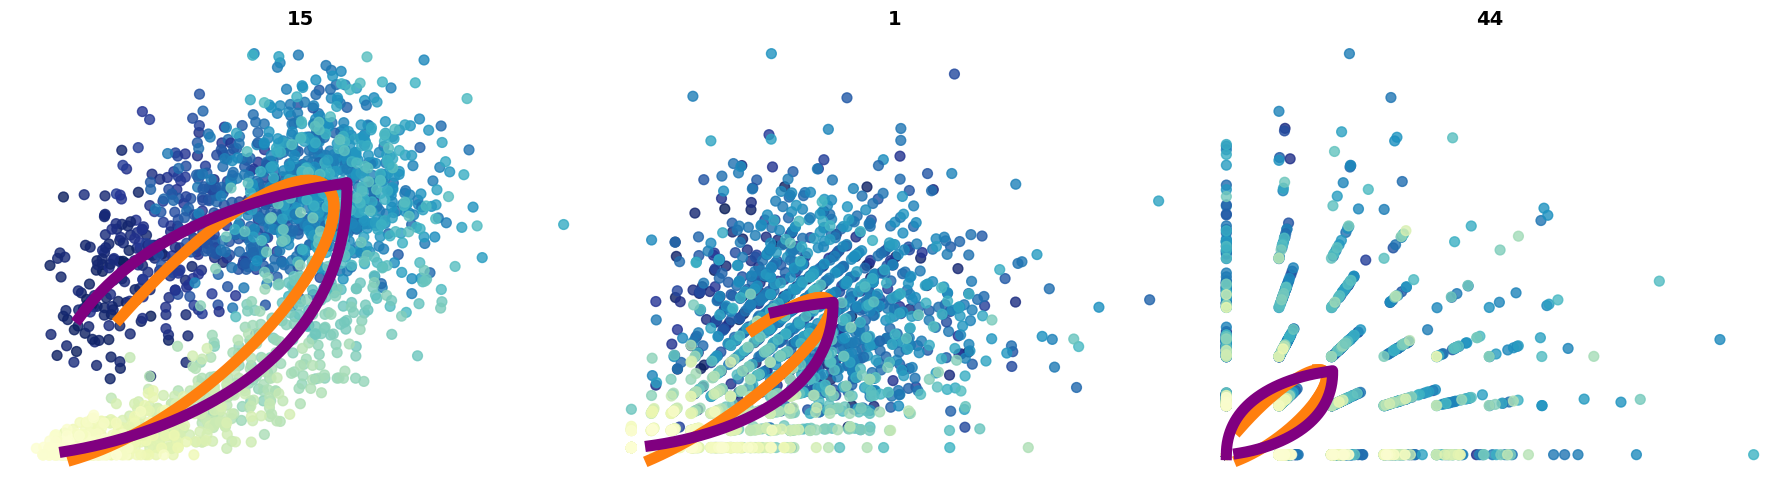

In [21]:
plot_range(['15','1','44'], adata_unitvelo, 
                  true_color='purple',
                  fit_color='#ff7f0e', 
                  cmap = 'YlGnBu_r',
                  config_file=velo,
                  size=50,
                  adata_true = adata_true,
    show_legend=False, show_ax=False,)